# Домашнее задание №1

Темы "Введение в МатСтат" и "Виды статистических оценок и характеристики"

Общие положения:
- Макс кол-во баллов за ДЗ - 25 баллов
- Качество оформления и кода играет роль

Список заданий:
1. Посчитайте кол-во уникальных жанров. (1 балл)
2. Посчитайте и визуализируйте средний рейтинг и стандартное отклонение по типу аниме `type`. (1 балл)
3. Посчитайте и визуализируйте средний рейтинг и стандартное отклонение по жанрам `genre`. (1 балл)
4. Посчитайте и визуализируйте квартили Q1, Q2 и Q3 с интерквантильным размахом по жанрам `genre` и типу аниме `type`. (1 балл)
5. Насколько часто встречаются аниме с одним или двумя жанрами? (1 балл)
6. Сколько в среднем эпизодов приходится на аниме типа == `TV`? (1 балл)
7. По правилу трех сигм на столбцах `episodes`, `rating` и `members` оцените кол-во аномалий. (1 балл)
  - если по одному из столбцов аниме не попадает в интервал трех сигм, то оно считается аномальным
8. Оцените и визуализируйте корреляцию среднего рейтинга жанра со средними кол-вом эпизодов и кол-вом подписчиков. (1 балл)
9. Оцените и визуализируйте корреляцию кол-ва жанров у аниме с его рейтингом и кол-вом подписчиков по каждому типу аниме `type`. (1 балл)
10. Оцените и визуализируйте корреляцию длины названия аниме `name` с его рейтингом, кол-вом жанров, эпизодов и подписчиков. (1 балл)



In [2]:
import numpy as np
import pandas as pd

# Не обязательно, можно использовать любую удобную вам библиотеку для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline

In [3]:
!curl -O https://raw.githubusercontent.com/practical-jupyter/sample-data/refs/heads/master/anime/anime.csv >> anime.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  778k  100  778k    0     0   358k      0  0:00:02  0:00:02 --:--:--  358k


Описание датафрейма:
- `anime_id` - ID
- `name` - название
- `genre` - жанр (строка с пречисление через запятую)
- `type` - формат
- `episodes` - кол-во эпизодов
- `rating` - средний рейтинг
- `members` - кол-во смотрящих

In [4]:
raw_df = pd.read_csv('anime.csv')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10486 entries, 0 to 10485
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  10486 non-null  int64  
 1   name      10486 non-null  object 
 2   genre     10424 non-null  object 
 3   type      10463 non-null  object 
 4   episodes  10486 non-null  object 
 5   rating    10275 non-null  float64
 6   members   10486 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 573.6+ KB


# 0. Utils

In [5]:
def visualize_histogram(x, y, xlabel: str, ylabel: str, title: str):
    plt.figure(figsize=(10, 6))
    plt.bar(x, y, color='skyblue')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def visualize_histogram_for_continous_values(data, bins, xlabel: str, ylabel: str, title: str):
    plt.figure(figsize=(10, 6))
    
    plt.hist(data, bins=bins, color='lightblue', edgecolor='black')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

## 1. Посчитайте кол-во уникальных жанров. (1 балл)

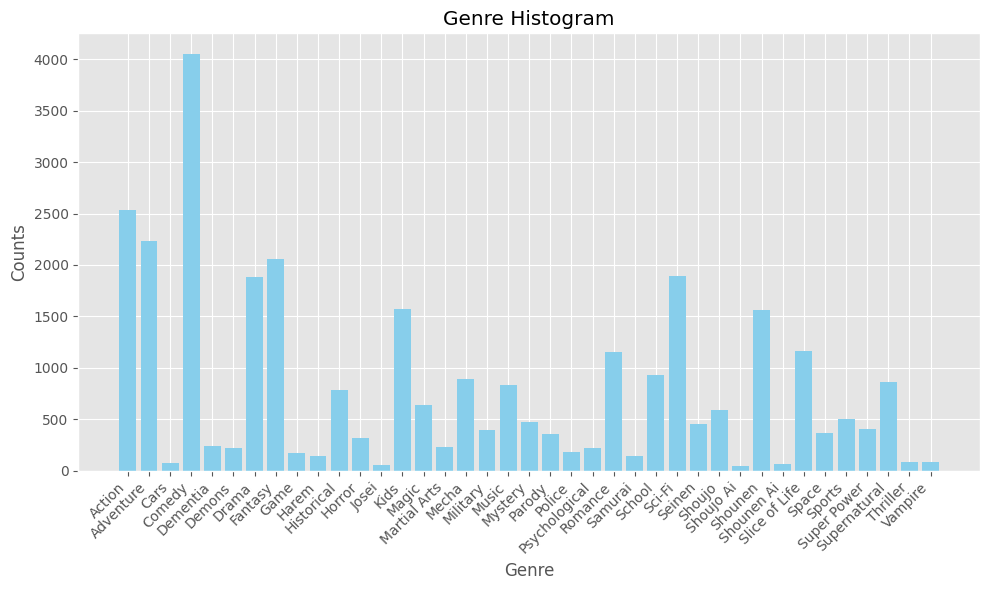

In [6]:
genre_df = raw_df.copy()
genre_df['processed_genre'] = genre_df['genre'].str.split(', ')
genre_df = genre_df.dropna()
genre_df['number_of_genres'] = genre_df['processed_genre'].apply(len)

genre_df = genre_df.explode('processed_genre')

genre_df['processed_genre'] = genre_df['processed_genre'].fillna('-1') # replace all NaN values
genre, genre_counts = np.unique(genre_df['processed_genre'], return_counts=True)

# Visualize genre histogram
visualize_histogram(genre, genre_counts, 'Genre', 'Counts', 'Genre Histogram')

## 2. Посчитайте и визуализируйте средний рейтинг и стандартное отклонение по типу аниме type. (1 балл)

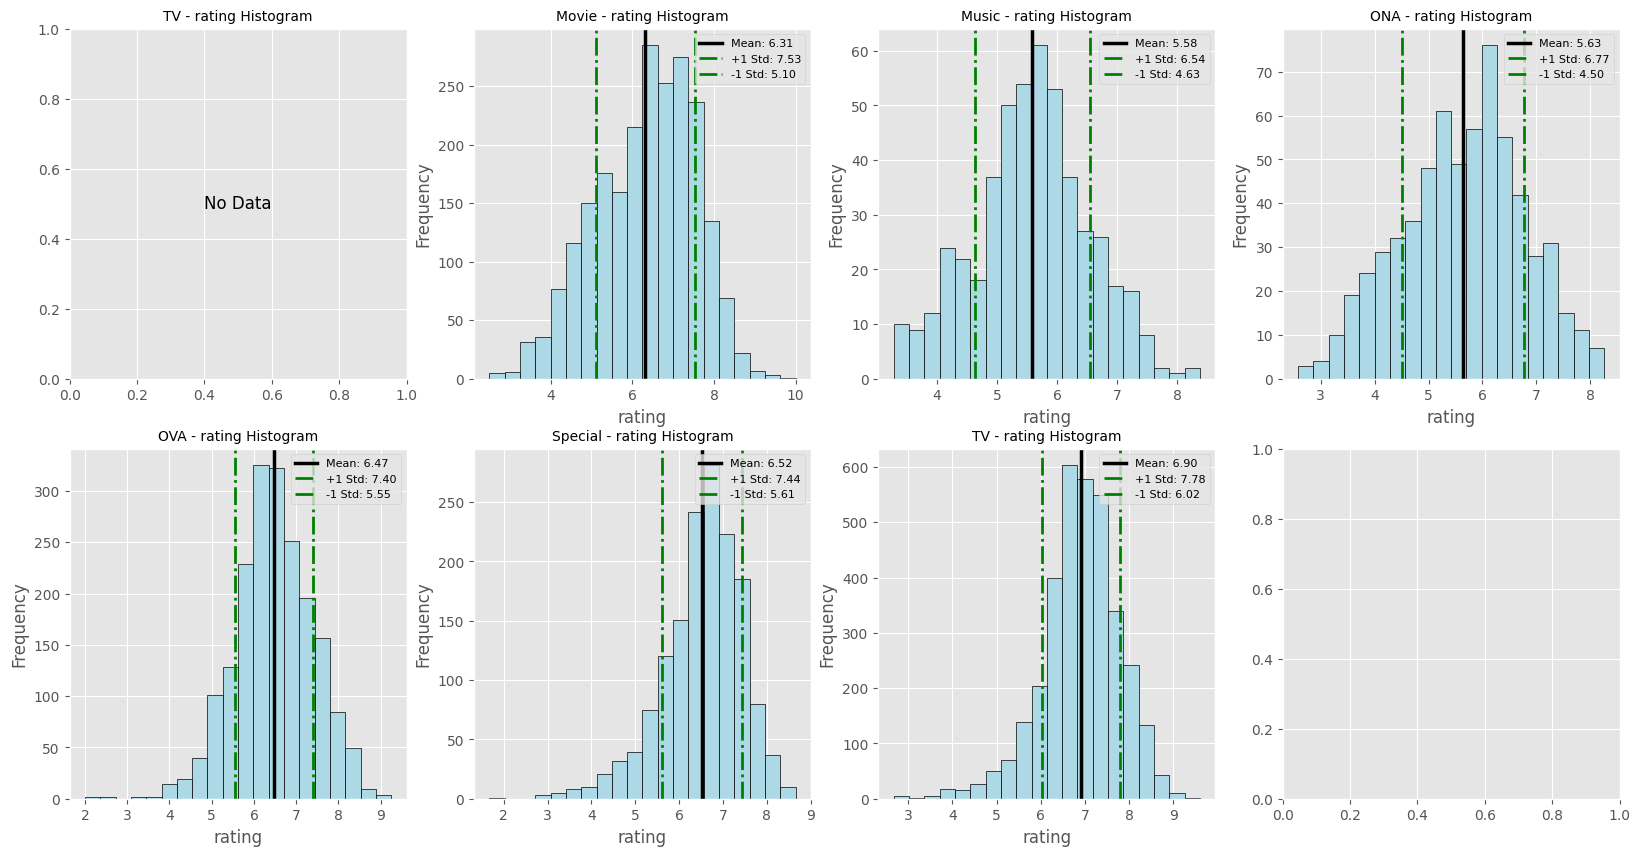

In [7]:
# First, I group the data by Type anime. For each group I calculated the mean and std
# NOTE : first chart with 'TV' title is empty, I didn't figure out why but it should have 'NaN' title, not 'TV'

categorical_col = 'type_categorical'
raw_df[categorical_col] = pd.Categorical(raw_df['type']).codes
groups = raw_df.groupby(categorical_col)

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.ravel()

for idx, (name, group) in enumerate(groups):
    category_label = pd.Categorical(raw_df['type']).categories[name]
    col = 'rating'
    clean_data = group[col].dropna()
    
    if clean_data.empty:  # If there are no valid (non-NaN) values, skip this plot
        axs[idx].text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', fontsize=12)
        axs[idx].set_title(f'{category_label} - {col} Histogram', fontsize=10)
        continue

    m = clean_data.mean()
    std = clean_data.std()

    axs[idx].hist(clean_data, bins=20, color='lightblue', edgecolor='black')
    axs[idx].set_title(f'{category_label} - {col} Histogram', fontsize=10)
    
    axs[idx].axvline(m, color='black', linestyle='-', linewidth=2.5, label=f'Mean: {m:.2f}')
    
    axs[idx].axvline(m + std, color='green', linestyle='-.', linewidth=2, label=f'+1 Std: {m + std:.2f}')
    axs[idx].axvline(m - std, color='green', linestyle='-.', linewidth=2, label=f'-1 Std: {m - std:.2f}')
    
    axs[idx].set_xlabel(col)
    axs[idx].set_ylabel('Frequency')

    axs[idx].legend(loc='upper right', fontsize=8)

## 3. Посчитайте и визуализируйте средний рейтинг и стандартное отклонение по жанрам. (1 балл)
График постройте для топ-15 жанров по рейтингу

In [8]:
# 1. Find top 15 genres
first_n_top_genres = 15
rating_of_first_n_top_genres = genre_df.groupby('processed_genre')['rating'].mean().sort_values(ascending=False).head(first_n_top_genres)
top_15_genres, _ = rating_of_first_n_top_genres.index, rating_of_first_n_top_genres.values

# 2. Get rating histogram, mean_rating, std_mean, and quantiles
from collections import defaultdict
genres_with_histogram_and_metrics = defaultdict()

for genre in top_15_genres:
    current_genre_df = genre_df[genre_df['processed_genre'] == genre]
    current_genre_df = current_genre_df[['rating']].dropna()  # Drop NaN values to not affect the metrics
    
    # Mean and standard deviation
    rating_mean = current_genre_df['rating'].mean()
    rating_std = current_genre_df['rating'].std()
    
    # Quantiles
    quantile_25 = current_genre_df['rating'].quantile(0.25)
    quantile_50 = current_genre_df['rating'].quantile(0.50)
    quantile_75 = current_genre_df['rating'].quantile(0.75)
    
    # Interquartile Range (IQR)
    iqr = quantile_75 - quantile_25
    
    genres_with_histogram_and_metrics[genre] = {
            'rating': current_genre_df['rating'],
            'mean': rating_mean,
            'std': rating_std,
            '25%': quantile_25,
            '50%': quantile_50,
            '75%': quantile_75,
            'IQR': iqr
        }

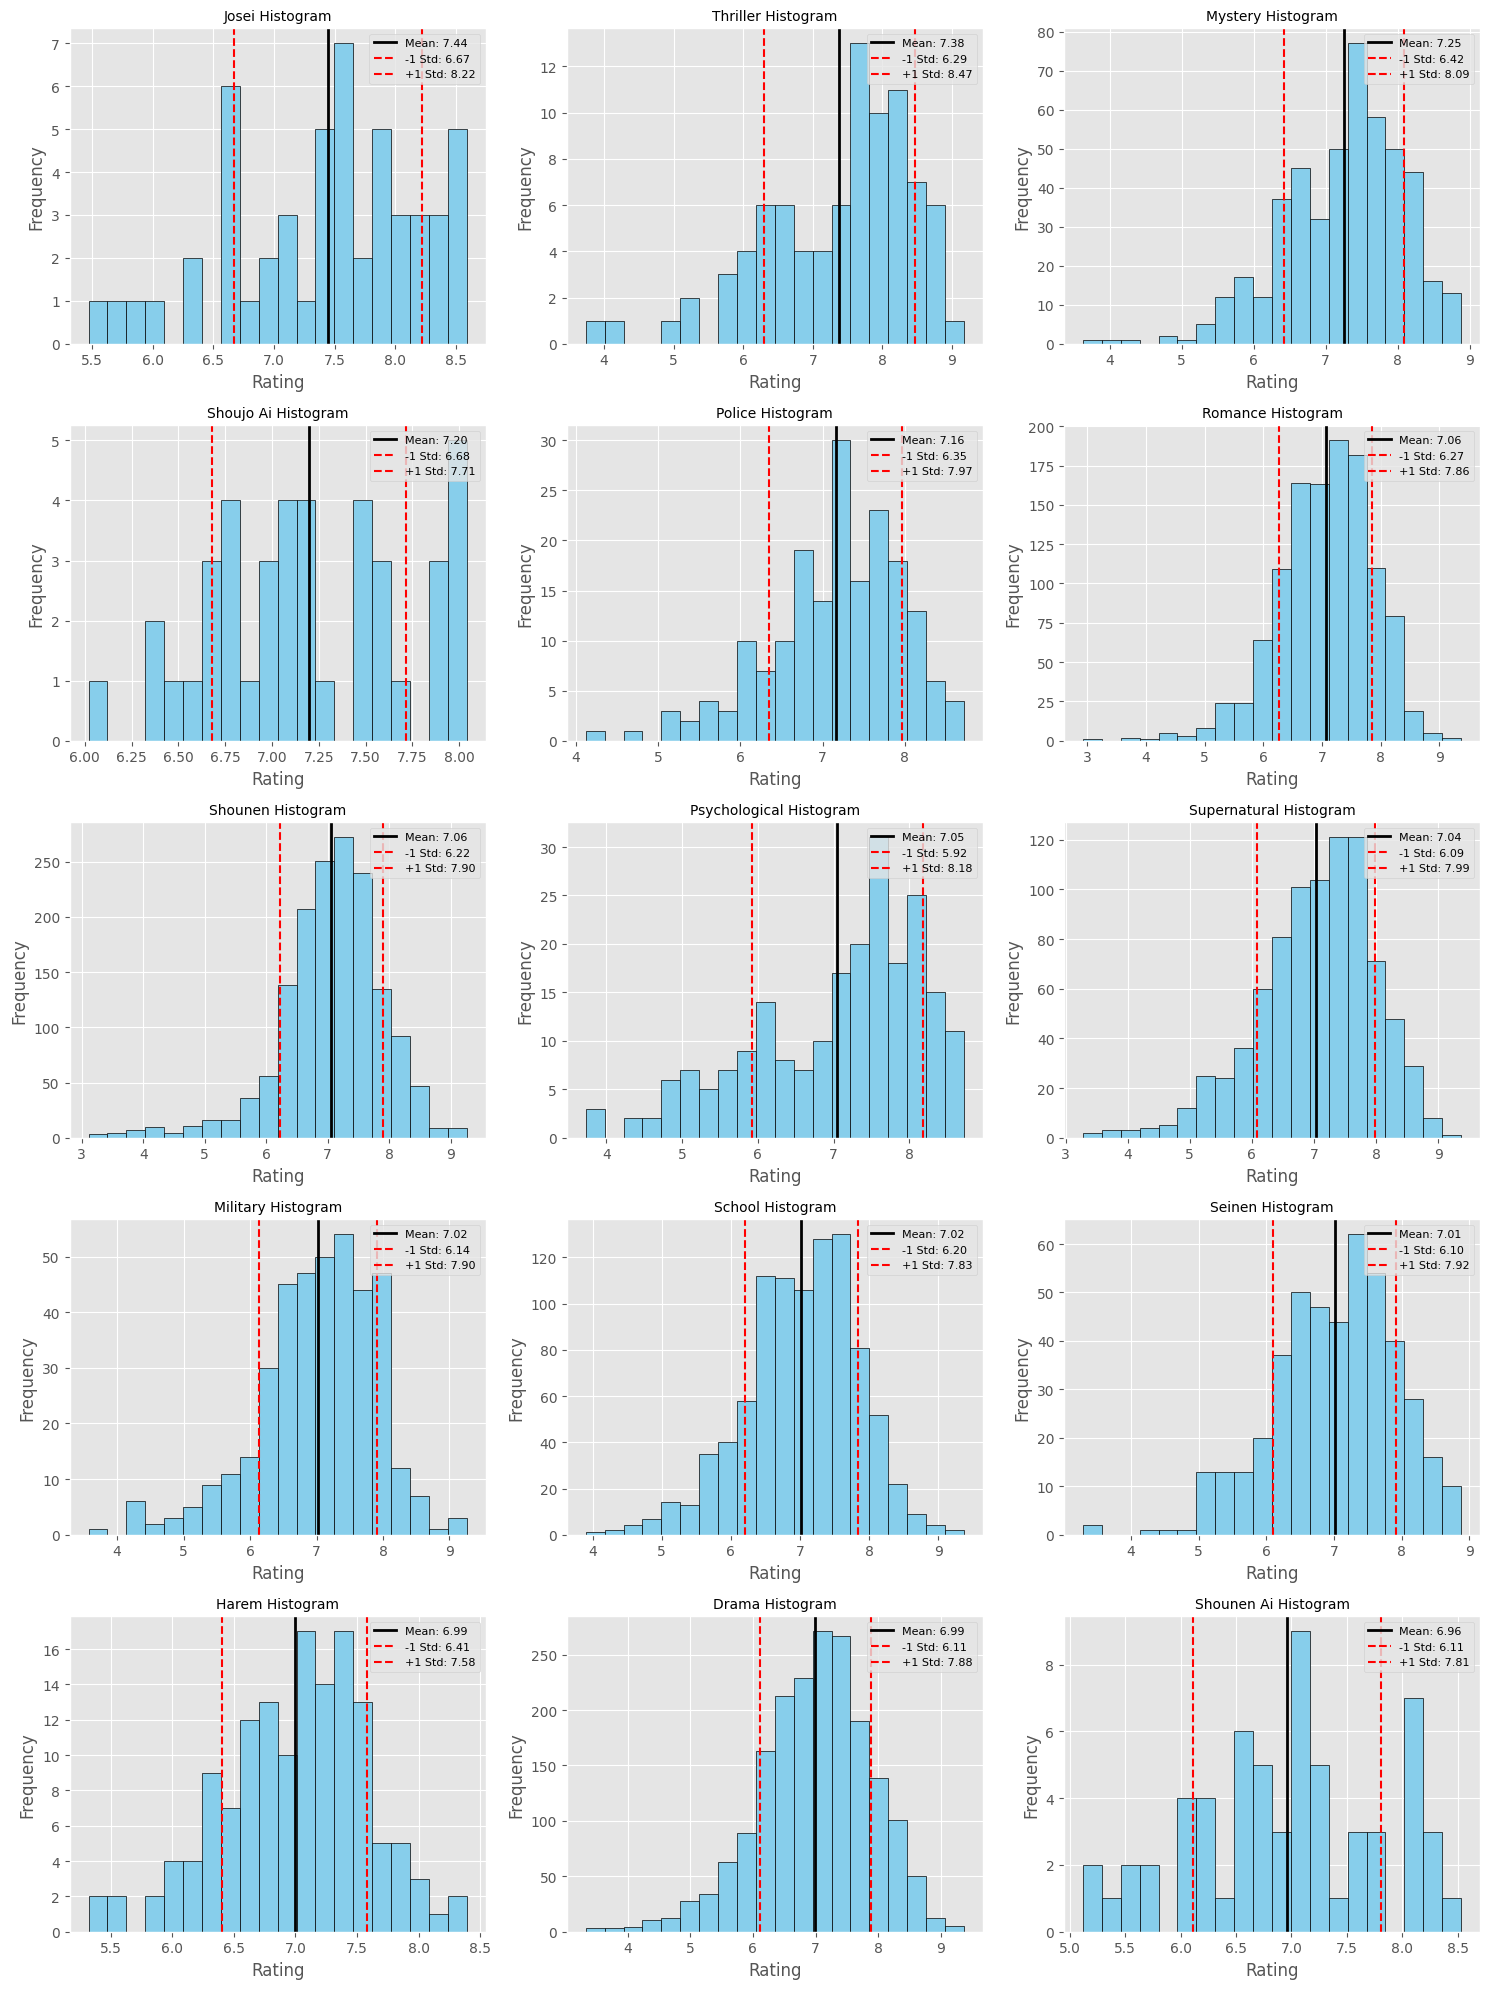

In [9]:
# 3. Visualize the plots

fig, axs = plt.subplots(5, 3, figsize=(15, 20))  # 5 rows, 3 columns for 15 plots

axs = axs.ravel()

for idx, genre_data in enumerate(genres_with_histogram_and_metrics):
    ratings = genres_with_histogram_and_metrics[genre_data]['rating']
    mean_rating = genres_with_histogram_and_metrics[genre_data]['mean']
    std_rating = genres_with_histogram_and_metrics[genre_data]['std']
    
    axs[idx].hist(ratings, bins=20, color='skyblue', edgecolor='black')
    axs[idx].set_title(f'{genre_data} Histogram', fontsize=10)
    
    axs[idx].axvline(mean_rating, color='black', linestyle='-', linewidth=2, label=f'Mean: {mean_rating:.2f}')
    axs[idx].axvline(mean_rating - std_rating, color='red', linestyle='--', linewidth=1.5, label=f'-1 Std: {mean_rating - std_rating:.2f}')
    axs[idx].axvline(mean_rating + std_rating, color='red', linestyle='--', linewidth=1.5, label=f'+1 Std: {mean_rating + std_rating:.2f}')
    
    axs[idx].legend(loc='upper right', fontsize=8)
    
    axs[idx].set_xlabel('Rating')
    axs[idx].set_ylabel('Frequency')

plt.tight_layout()


## 4. Посчитайте и визуализируйте квартили Q1, Q2 и Q3 с интерквантильным размахом по жанрам genre и типу аниме type. (1 балл)

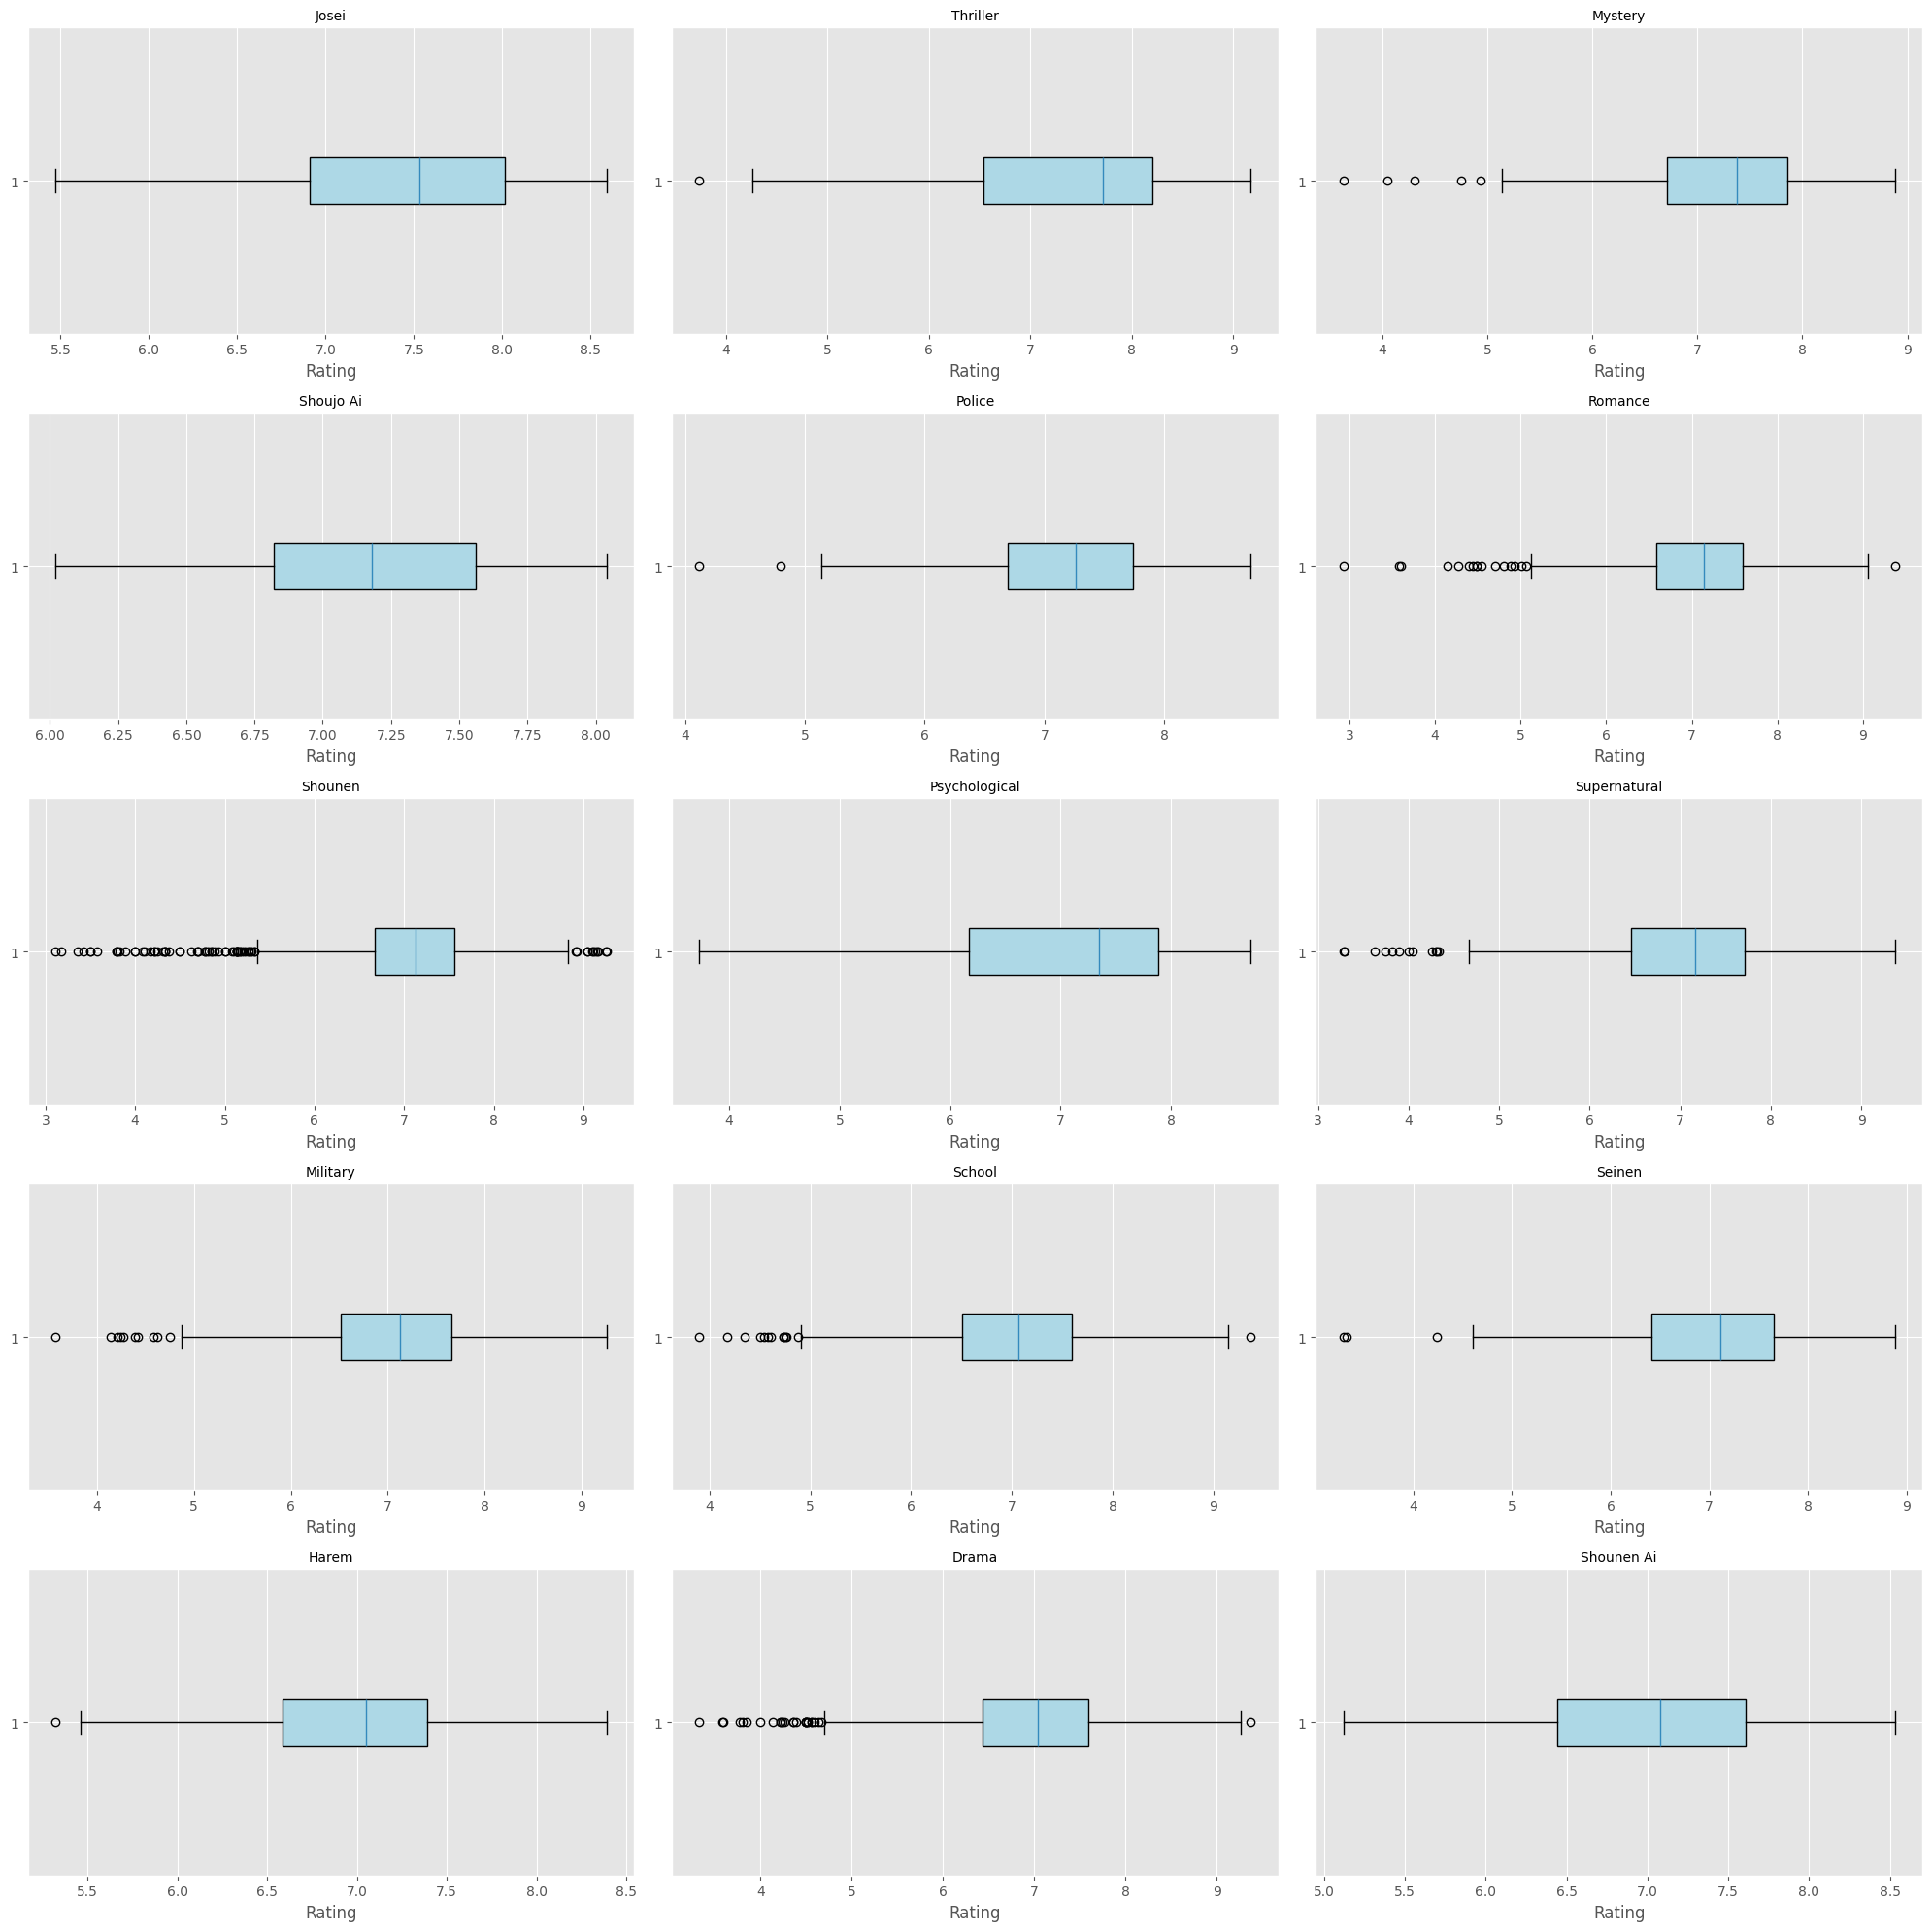

In [10]:
# 1. Genre
fig, axs = plt.subplots(5, 3, figsize=(20, 20))
axs = axs.ravel()  

for idx, genre in enumerate(genres_with_histogram_and_metrics):
    data = genres_with_histogram_and_metrics[genre]['rating']
    
    axs[idx].boxplot(data, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    axs[idx].set_title(f'{genre}', fontsize=10)
    
    axs[idx].set_xlabel('Rating')

plt.tight_layout()

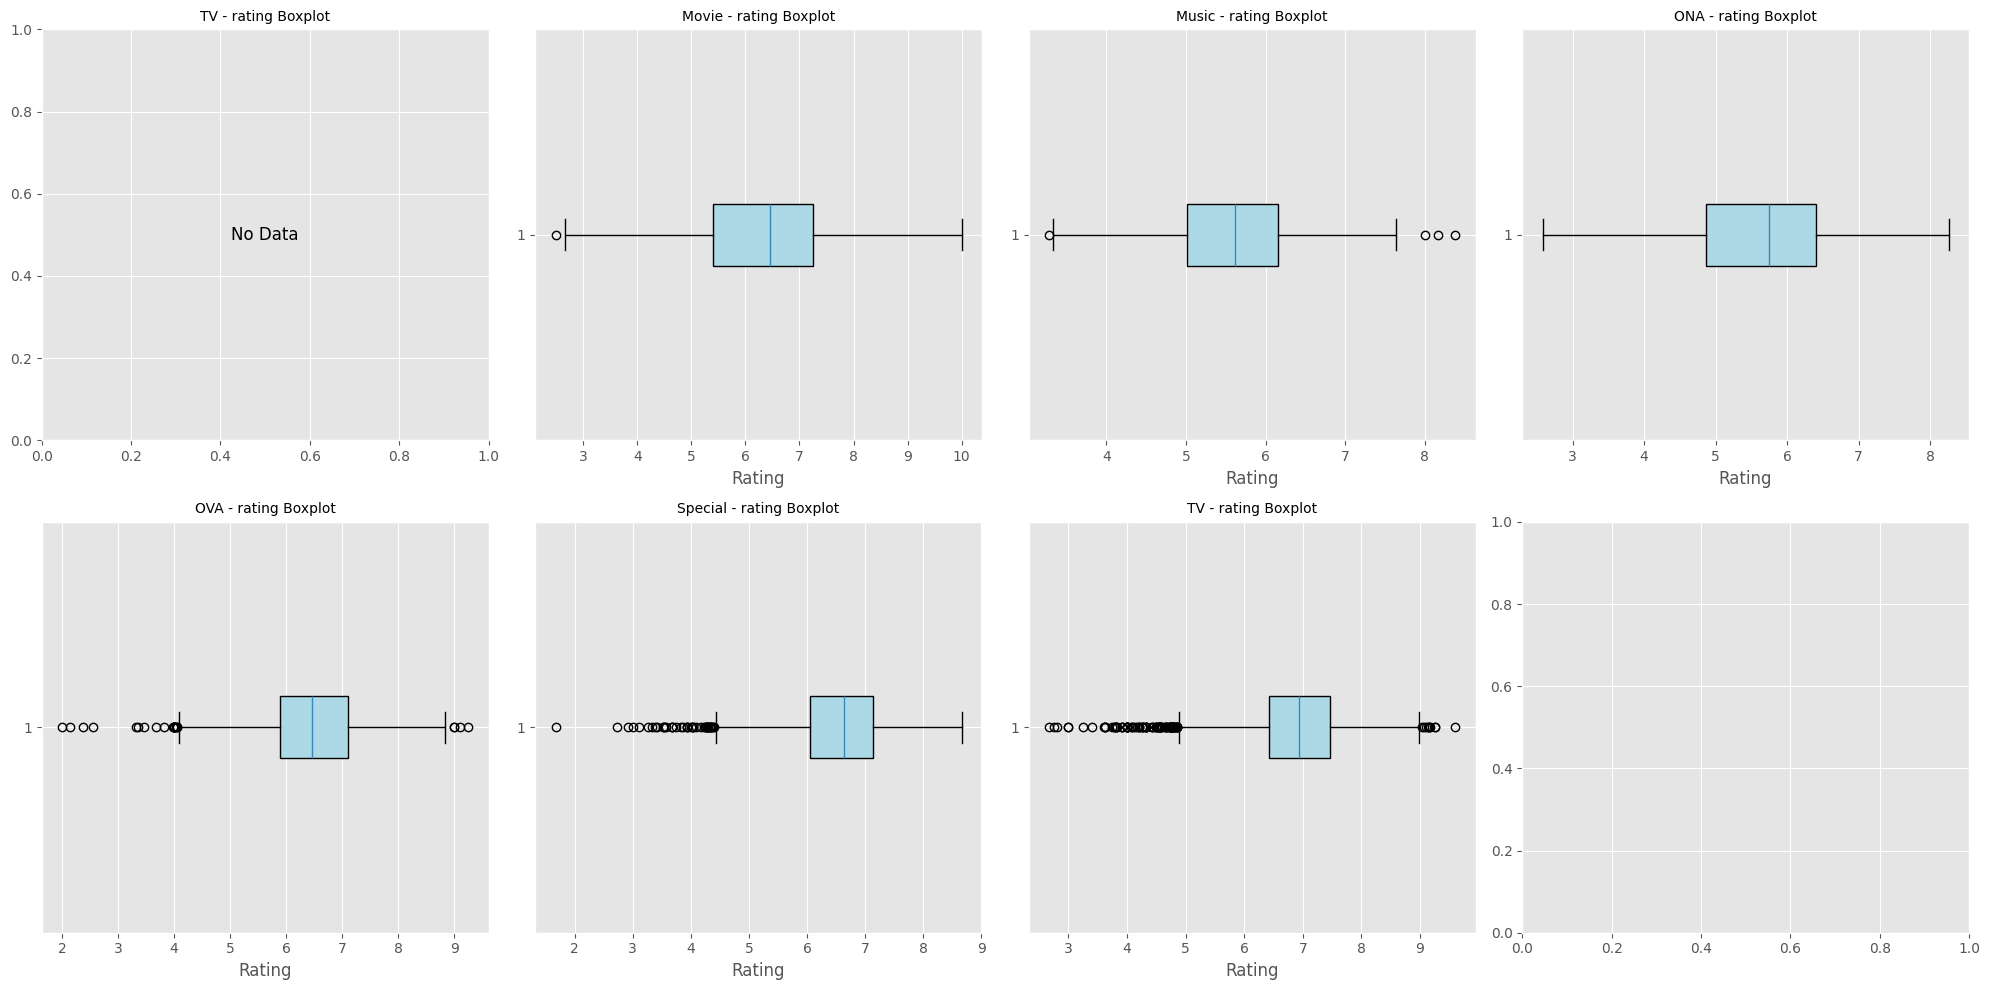

In [11]:
# 2. Type
categorical_col = 'type_categorical'
raw_df[categorical_col] = pd.Categorical(raw_df['type']).codes
groups = raw_df.groupby(categorical_col)

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.ravel()

for idx, (name, group) in enumerate(groups):
    category_label = pd.Categorical(raw_df['type']).categories[name]
    col = 'rating'

    clean_data = group[col].dropna()
    
    if clean_data.empty:
        axs[idx].text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', fontsize=12)
        axs[idx].set_title(f'{category_label} - {col} Boxplot', fontsize=10)
        continue

    axs[idx].boxplot(clean_data, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    axs[idx].set_title(f'{category_label} - {col} Boxplot', fontsize=10)
    
    axs[idx].set_xlabel('Rating')

plt.tight_layout()

## 5. Насколько часто встречаются аниме с одним или двумя жанрами? (1 балл)

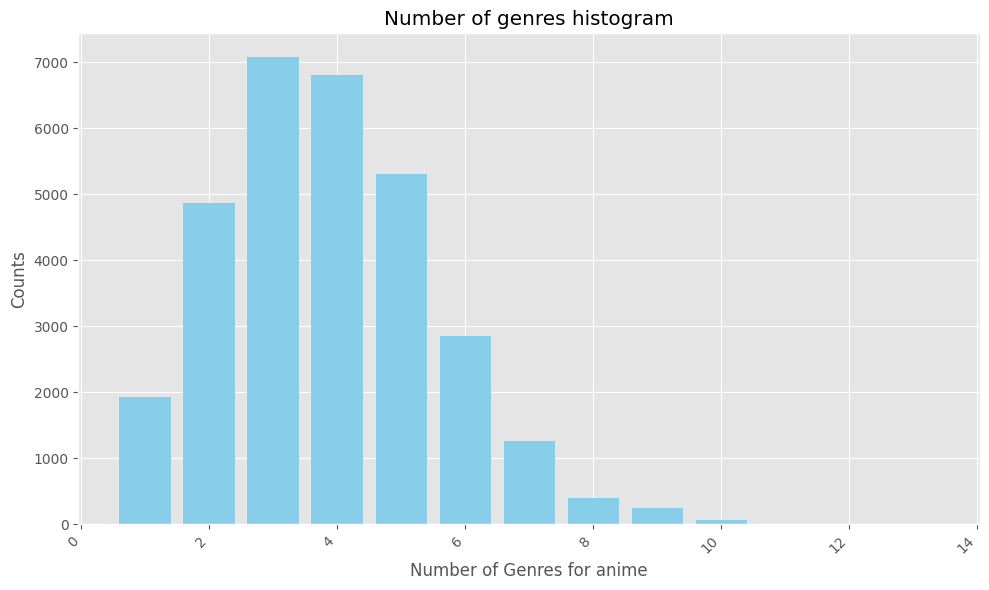

In [12]:
number_of_genres, counts = np.unique(genre_df['number_of_genres'], return_counts=True)
visualize_histogram(number_of_genres, counts, 'Number of Genres for anime', 'Counts', 'Number of genres histogram')

## 6. Сколько в среднем эпизодов приходится на аниме типа == TV? (1 балл)

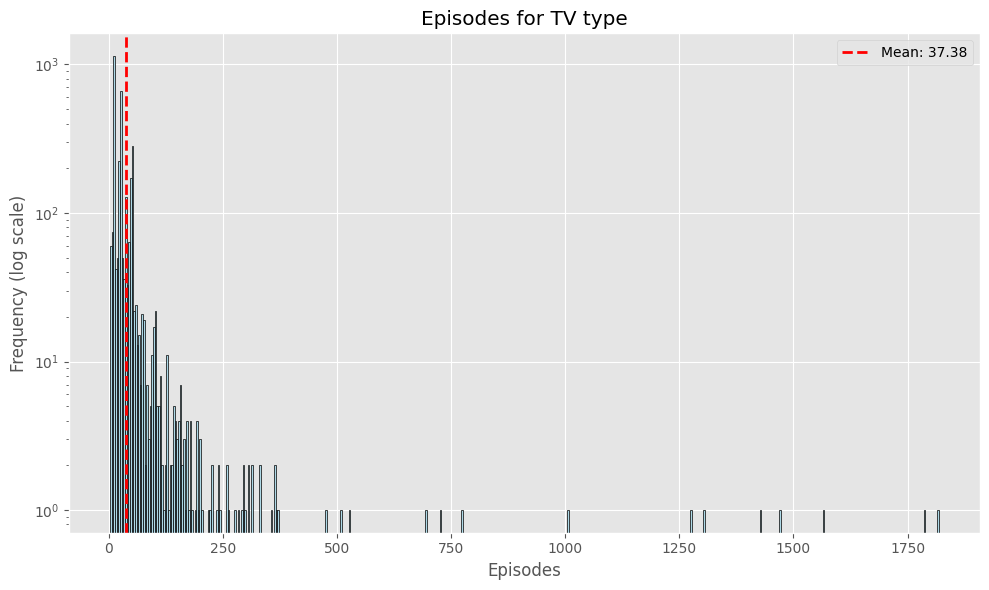

In [13]:
import matplotlib.pyplot as plt

def visualize_logarithmic_histogram_with_mean(data, bins, xlabel: str, ylabel: str, title: str):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, color='lightblue', edgecolor='black')
    mean_value = data.mean()
    plt.axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')
    
    plt.yscale('log')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    plt.legend(loc='upper right')
    
    plt.tight_layout()

only_tv_df = raw_df[raw_df['type'] == 'TV']
only_tv_df.loc[:, 'episodes'] = pd.to_numeric(only_tv_df['episodes'], errors='coerce')
only_tv_df = only_tv_df.dropna(subset=['episodes'])

visualize_logarithmic_histogram_with_mean(only_tv_df['episodes'], 500, 'Episodes', 'Frequency (log scale)', 'Episodes for TV type')


## 7. По правилу трех сигм на столбцах episodes, rating и members оцените кол-во аномалий. (1 балл)
если по одному из столбцов аниме не попадает в интервал трех сигм, то оно считается аномальным


In [14]:
anime_df = raw_df.copy()
anime_df['episodes'] = pd.to_numeric(raw_df['episodes'], errors='coerce')
anime_df = anime_df.dropna(subset=['rating'])

columns_to_analyze = ['episodes', 'rating', 'members']
mean_std_info = anime_df[columns_to_analyze].agg(['mean', 'std'])

def count_anomalies(column):
    mean = mean_std_info[column]['mean']
    std_dev = mean_std_info[column]['std']
    lower_bound = mean - 3 * std_dev
    upper_bound = mean + 3 * std_dev
    anomalies = anime_df[(anime_df[column] < lower_bound) | (anime_df[column] > upper_bound)]
    return len(anomalies)

anomalies_count = {col: count_anomalies(col) for col in columns_to_analyze}
anomalies_count


{'episodes': 63, 'rating': 41, 'members': 213}

## 8. Оцените и визуализируйте корреляцию среднего рейтинга жанра со средними кол-вом эпизодов и кол-вом подписчиков. (1 балл)

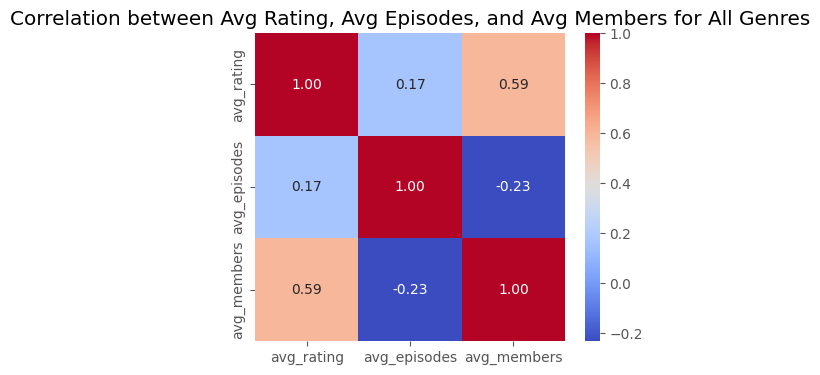

In [15]:
genre_df['episodes'] = pd.to_numeric(raw_df['episodes'], errors='coerce')
genre_grouped = genre_df.groupby('processed_genre').agg(
    avg_rating=('rating', 'mean'),
    avg_episodes=('episodes', 'mean'),
    avg_members=('members', 'mean')
).reset_index()

correlation_matrix = genre_grouped[['avg_rating', 'avg_episodes', 'avg_members']].corr()
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Avg Rating, Avg Episodes, and Avg Members for All Genres')
plt.show()



## 9. Оцените и визуализируйте корреляцию кол-ва жанров у аниме с его рейтингом и кол-вом подписчиков по каждому типу аниме type. (1 балл)

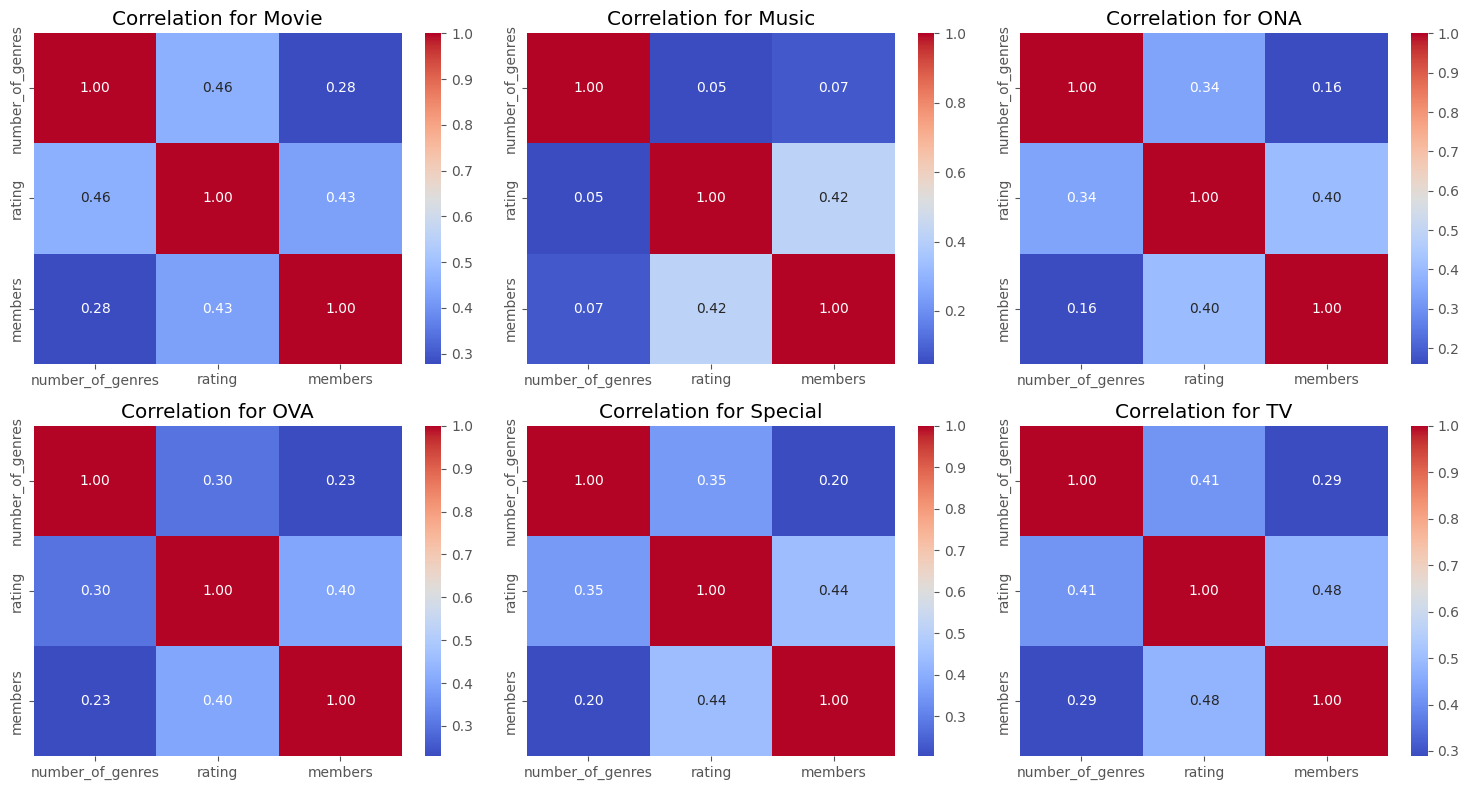

In [16]:
# For each anime type --> number of genres | rating  | members
def get_number_of_genres(genres: str):
    list_with_genres = genres.split(', ')
    return len(list_with_genres)

df = raw_df.copy()
df = df.dropna(subset=['genre'])
df['number_of_genres'] = df['genre'].apply(get_number_of_genres)

grouped_based_on_type = df.groupby('type')
correlation_matrix_for_type_groups = defaultdict()
for group_name, group_data in grouped_based_on_type:
    correlation_matrix_for_type_groups[group_name] = group_data[['number_of_genres', 'rating', 'members']].corr()

num_groups = len(correlation_matrix_for_type_groups)
nrows = 2  
ncols = int(np.ceil(num_groups / nrows))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()
for ax, (group_type, correlation_matrix) in zip(axes, correlation_matrix_for_type_groups.items()):
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=ax)
    ax.set_title(f'Correlation for {group_type}')

for ax in axes[num_groups:]:
    fig.delaxes(ax)

plt.tight_layout()

## 10. Оцените и визуализируйте корреляцию длины названия аниме name с его рейтингом, кол-вом жанров, эпизодов и подписчиков. (1 балл)

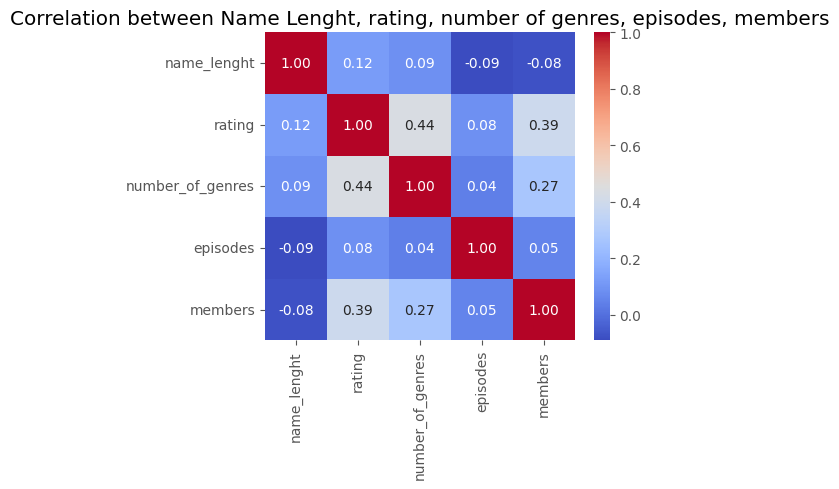

In [17]:
df['name_lenght'] = df['name'].apply(len)
df['episodes'] = pd.to_numeric(df['episodes'], errors='coerce')
correlation_matrix_task_10 = df[['name_lenght', 'rating', 'number_of_genres', 'episodes', 'members']].corr()
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix_task_10, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Name Lenght, rating, number of genres, episodes, members')
plt.show()

# 2. Часть

Каждое задание оценивается 1 баллом в случае полного выполнения

 ### Задание 11: Нормальное распределение (1 балл)
**Генерация данных**
Сгенерируйте выборку из 1000 элементов с нормальным распределением, где среднее  μ=5 и стандартное отклонение σ=1.5.

**Описательная статистика**
Рассчитайте выборочное среднее, выборочную медиану, выборочную моду и стандартное отклонение.

**Графическое представление**
Постройте гистограмму и график плотности распределения. Сравните выборочные статистики с теоретическими.

**Анализ отклонений**
Рассчитайте частоту значений, которые отклоняются от среднего на более чем одно стандартное отклонение, и сравните это с теоретическим результатом для нормального распределения.

In [168]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import bernoulli, binom, geom, poisson, expon, norm, mode
# from ipywidgets import interact, FloatSlider, IntSlider
import warnings
warnings.filterwarnings('ignore')
# %matplotlib inline

# Input parameters
mu = 5
sigma = 1.5

# normal_mean
normal_mean = mu
normal_median = mu
normal_mode = mu
normal_std = sigma

# Step 1: Get samples
sample_size = 1000
samples = norm.rvs(mu, sigma, size=sample_size)

# Step 2: Descriptive statistics
sample_mean = np.mean(samples)
sample_median = np.median(samples)
sample_mode, _ = mode(np.round(samples))  
sample_std = np.std(samples, ddof=1)

data = {
    "Statistic": ["Mean", "Median", "Standard Deviation", "Mode"],
    "Sample Value": [sample_mean, sample_median, sample_std, sample_mode],
    "Theoretical Value": [normal_mean, normal_median, normal_std, normal_mode]
}
df = pd.DataFrame(data)

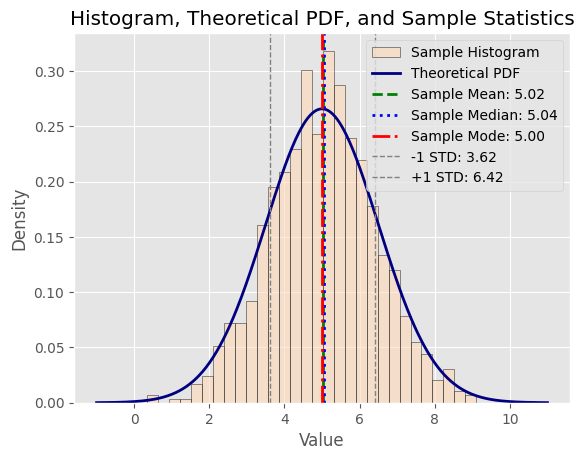

Частота значений, которые отклоняются более чем на 1 st для выборки: 32.10%
Частота для теоритического распределения : 32%


,Statistic,Sample Value,Theoretical Value
0,Mean,5.020179,5.0
1,Median,5.041536,5.0
2,Standard Deviation,1.395439,1.5
3,Mode,5.000000,5.0


In [169]:
def visualize_normal_with_samples(samples, mu, sigma, sample_mean, sample_median, sample_mode, sample_std):
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 400)
    pdf = norm.pdf(x, mu, sigma)
    
    # Histogram
    plt.hist(samples, bins=30, density=True, alpha=0.6, color='peachpuff', edgecolor='black', label='Sample Histogram')

    # Theoretical PDF
    plt.plot(x, pdf, color='navy', lw=2, label='Theoretical PDF')

    # Add mean, median, mode, and std devs
    plt.axvline(sample_mean, color='green', linestyle='--', lw=2, label=f'Sample Mean: {sample_mean:.2f}')
    plt.axvline(sample_median, color='blue', linestyle=':', lw=2, label=f'Sample Median: {sample_median:.2f}')
    plt.axvline(sample_mode, color='red', linestyle='-.', lw=2, label=f'Sample Mode: {sample_mode:.2f}')
    plt.axvline(sample_mean - sample_std, color='gray', linestyle='--', lw=1, label=f'-1 STD: {sample_mean - sample_std:.2f}')
    plt.axvline(sample_mean + sample_std, color='gray', linestyle='--', lw=1, label=f'+1 STD: {sample_mean + sample_std:.2f}')

    # Titles and labels
    plt.title('Histogram, Theoretical PDF, and Sample Statistics')
    plt.xlabel('Value')
    plt.ylabel('Density')

    plt.legend()
    plt.show()

visualize_normal_with_samples(samples, mu, sigma, sample_mean, sample_median, sample_mode, sample_std)

deviation_threshold = sample_std  # One standard deviation
deviation_values = samples[np.abs(samples - sample_mean) > deviation_threshold]
frequency = len(deviation_values) / len(samples)
print(f"Частота значений, которые отклоняются более чем на 1 st для выборки: {frequency * 100:.2f}%")
print(f"Частота для теоритического распределения : 32%")

df

### Задание 12: Экспоненциальное распределение (1 балл)
Генерация данных \
Сгенерируйте выборку из 1000 элементов из экспоненциального распределения с параметром λ=0.5. \
Описательная статистика \
Рассчитайте выборочное среднее, медиану и стандартное отклонение. \
Графическое представление \
Постройте гистограмму и график плотности распределения. \
Анализ распределения \
Определите долю значений в выборке, которые больше двух выборочных средних, и сравните это с теоретической вероятностью для экспоненциального распределения. \

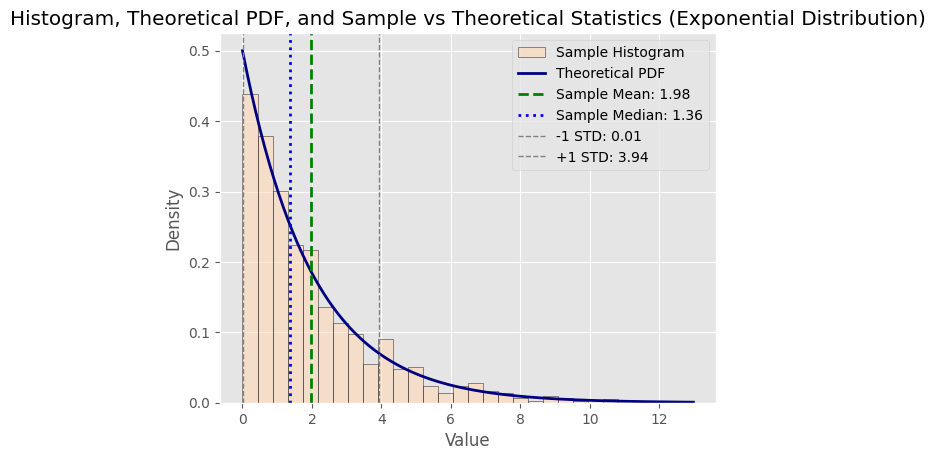

Доля значений, которые больше двух выборочных средних: 14.70%
Теоретическая вероятность для экспоненциального распределения: 13.53%


,Statistic,Sample Value,Theoretical Value
0,Mean,1.975313,2.000000
1,Median,1.358230,1.386294
2,Standard Deviation,1.964869,2.000000


In [170]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon

# Input parameters
lambda_param = 0.5

# Step 1: Get samples from exponential distribution
sample_size = 1000
samples = expon.rvs(scale=1/lambda_param, size=sample_size)

# Step 2: Descriptive statistics
sample_mean = np.mean(samples)
sample_median = np.median(samples)
sample_std = np.std(samples, ddof=1)

theoretical_mean = 1 / lambda_param
theoretical_median = np.log(2) / lambda_param
theoretical_std = 1 / lambda_param

data = {
    "Statistic": ["Mean", "Median", "Standard Deviation"],
    "Sample Value": [sample_mean, sample_median, sample_std],
    "Theoretical Value": [theoretical_mean, theoretical_median, theoretical_std]
}
df = pd.DataFrame(data)


def visualize_exponential_with_theoretical_stats(samples, lambda_param, sample_mean, sample_median, sample_std):
    x = np.linspace(0, np.max(samples), 400)
    pdf = expon.pdf(x, scale=1/lambda_param)
    
    # Theoretical statistics
    theoretical_mean = 1 / lambda_param
    theoretical_median = np.log(2) / lambda_param
    theoretical_std = 1 / lambda_param

    # Histogram
    plt.hist(samples, bins=30, density=True, alpha=0.6, color='peachpuff', edgecolor='black', label='Sample Histogram')

    # Theoretical PDF
    plt.plot(x, pdf, color='navy', lw=2, label='Theoretical PDF')

    # Add sample mean, median, and std devs
    plt.axvline(sample_mean, color='green', linestyle='--', lw=2, label=f'Sample Mean: {sample_mean:.2f}')
    plt.axvline(sample_median, color='blue', linestyle=':', lw=2, label=f'Sample Median: {sample_median:.2f}')
    plt.axvline(sample_mean - sample_std, color='gray', linestyle='--', lw=1, label=f'-1 STD: {sample_mean - sample_std:.2f}')
    plt.axvline(sample_mean + sample_std, color='gray', linestyle='--', lw=1, label=f'+1 STD: {sample_mean + sample_std:.2f}')

    # Titles and labels
    plt.title('Histogram, Theoretical PDF, and Sample vs Theoretical Statistics (Exponential Distribution)')
    plt.xlabel('Value')
    plt.ylabel('Density')

    plt.legend()
    plt.show()

visualize_exponential_with_theoretical_stats(samples, lambda_param, sample_mean, sample_median, sample_std)


# Step 3: Calculate proportion of values greater than two times the sample mean
threshold = 2 * sample_mean
above_threshold_values = samples[samples > threshold]
sample_proportion = len(above_threshold_values) / len(samples)

# Theoretical probability P(X > 2 * mean) for exponential distribution
theoretical_proportion = np.exp(-2)  # since P(X > a) = exp(-lambda * a) and mean = 1/lambda

print(f"Доля значений, которые больше двух выборочных средних: {sample_proportion * 100:.2f}%")
print(f"Теоретическая вероятность для экспоненциального распределения: {theoretical_proportion * 100:.2f}%")

df


### Задание 13: Биномиальное распределение (1 балл)
Генерация данных \
Сгенерируйте выборку из 1000 наблюдений из биномиального распределения с параметрами  n=10 и p=0.7 \
Описательная статистика \
Найдите выборочное среднее, дисперсию и моду количества успехов. \
Графическое представление \
Постройте столбчатую диаграмму распределения количества успехов. \
Анализ вероятностей \
Вычислите вероятность того, что количество успехов будет больше 8, используя как выборочные данные, так и теоретическую вероятность биномиального распределения. Сравните результаты. \

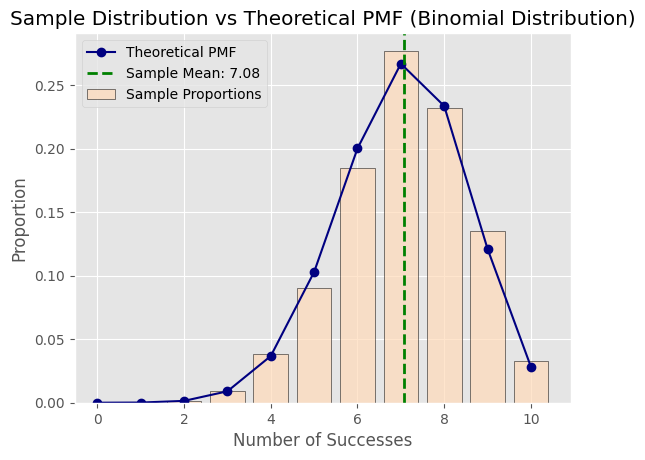

Доля значений, которые больше 8: 16.80%
Теоретическая вероятность для биномиального распределения: 14.93%


,Statistic,Sample Value,Theoretical Value
0,Mean,7.08100,7.0
1,Variance,2.12056,2.1
2,Mode,7.00000,N/A


In [171]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from collections import Counter

# Step 1: Generate a sample of 1000 observations from a binomial distribution with n=10 and p=0.7
n = 10
p = 0.7
sample_size = 1000
samples = np.random.binomial(n, p, sample_size)

# Step 2: Calculate sample mean, variance, and mode
sample_mean = np.mean(samples)
sample_variance = np.var(samples, ddof=1)  # ddof=1 for unbiased estimator
sample_mode, _ = mode(np.round(samples))  

# Theoretical values
theoretical_mean = n * p
theoretical_variance = n * p * (1 - p)

# Organize the results in a DataFrame
data = {
    "Statistic": ["Mean", "Variance", "Mode"],
    "Sample Value": [sample_mean, sample_variance, sample_mode],
    "Theoretical Value": [theoretical_mean, theoretical_variance, "N/A"]
}
df = pd.DataFrame(data)

# Step 3: Plot bar chart for the distribution of the number of successes
def plot_binomial_distribution(samples, n, p, sample_mean):
    # Create bar chart for sample distribution
    values, counts = np.unique(samples, return_counts=True)
    plt.bar(values, counts/sample_size, alpha=0.7, color='peachpuff', edgecolor='black', label='Sample Proportions')

    # Theoretical probabilities
    x = np.arange(0, n+1)
    pmf = binom.pmf(x, n, p)
    plt.plot(x, pmf, color='navy', marker='o', linestyle='-', label='Theoretical PMF')

    plt.axvline(sample_mean, color='green', linestyle='--', lw=2, label=f'Sample Mean: {sample_mean:.2f}')

    # Add titles and labels
    plt.title('Sample Distribution vs Theoretical PMF (Binomial Distribution)')
    plt.xlabel('Number of Successes')
    plt.ylabel('Proportion')

    plt.legend()
    plt.show()

plot_binomial_distribution(samples, n, p, sample_mean)

# Step 4: Calculate the proportion of successes greater than 8 in the sample
threshold = 8
sample_proportion = np.sum(samples > threshold) / sample_size

# Theoretical probability P(X > 8) for binomial distribution
theoretical_proportion = 1 - binom.cdf(threshold, n, p)

print(f"Доля значений, которые больше 8: {sample_proportion * 100:.2f}%")
print(f"Теоретическая вероятность для биномиального распределения: {theoretical_proportion * 100:.2f}%")

# Show the DataFrame
df


### Задание 14: Геометрическое распределение (1 балл)
Генерация данных \
Сгенерируйте выборку из 1000 наблюдений из геометрического распределения с вероятностью успеха p=0.3. \
Описательная статистика \
Рассчитайте выборочное среднее, медиану и моду количества попыток до первого успеха. \
Графическое представление \
Постройте гистограмму распределения количества попыток. \
Анализ вероятностей \
Определите вероятность того, что потребуется не более 5 попыток для первого успеха, используя как выборочные данные, так и теоретическое геометрическое распределение. Сравните результаты. \

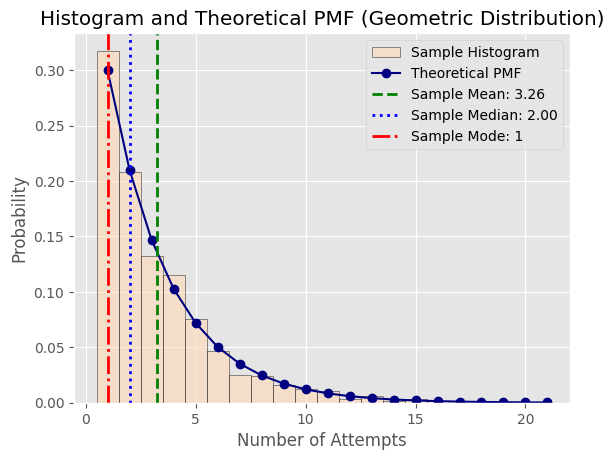

Доля попыток, не превышающих 5 для выборки: 84.70%
Теоретическая вероятность не более 5 попыток: 83.19%


,Statistic,Sample Value,Theoretical Value
0,Mean,3.259,3.333333
1,Median,2.000,2.000000
2,Mode,1.000,1.000000


In [196]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import geom, mode
import pandas as pd

# Step 1: Generate a sample of 1000 observations from a geometric distribution with p=0.3
p = 0.3
sample_size = 1000
samples = geom.rvs(p, size=sample_size)

# Theoretical values for a geometric distribution
theoretical_mean = 1 / p
theoretical_median = np.ceil(np.log(0.5) / np.log(1 - p))  # Median formula for geometric distribution
theoretical_mode = 1  # Mode for geometric distribution is always 1

# Step 2: Calculate sample mean, median, and mode
sample_mean = np.mean(samples)
sample_median = np.median(samples)
sample_mode, _ = mode(np.round(samples))
# sample_mode, _ = mode(samples)

# Organize the results in a DataFrame
data = {
    "Statistic": ["Mean", "Median", "Mode"],
    "Sample Value": [sample_mean, sample_median, sample_mode],
    "Theoretical Value": [theoretical_mean, theoretical_median, theoretical_mode]
}
df = pd.DataFrame(data)

# Step 3: Plot a histogram for the distribution of the number of attempts
def visualize_geometric_distribution(samples, p, sample_mean, sample_median, sample_mode):
    # Create histogram of the sample data
    plt.hist(samples, bins=np.arange(1, max(samples)+1)-0.5, density=True, alpha=0.6, color='peachpuff', edgecolor='black', label='Sample Histogram')

    # Theoretical PMF
    x = np.arange(1, max(samples)+1)
    pmf = geom.pmf(x, p)
    plt.plot(x, pmf, color='navy', marker='o', linestyle='-', label='Theoretical PMF')

    # Add sample mean, median, mode lines
    plt.axvline(sample_mean, color='green', linestyle='--', lw=2, label=f'Sample Mean: {sample_mean:.2f}')
    plt.axvline(sample_median, color='blue', linestyle=':', lw=2, label=f'Sample Median: {sample_median:.2f}')
    plt.axvline(sample_mode, color='red', linestyle='-.', lw=2, label=f'Sample Mode: {sample_mode}')

    # Add titles and labels
    plt.title('Histogram and Theoretical PMF (Geometric Distribution)')
    plt.xlabel('Number of Attempts')
    plt.ylabel('Probability')

    plt.legend()
    plt.show()

visualize_geometric_distribution(samples, p, sample_mean, sample_median, sample_mode)

# Step 4: Calculate the proportion of attempts <= 5 for both the sample and theoretical distribution
threshold = 5
sample_proportion = np.sum(samples <= threshold) / sample_size

# Theoretical probability P(X <= 5) for geometric distribution
theoretical_proportion = geom.cdf(threshold, p)

print(f"Доля попыток, не превышающих 5 для выборки: {sample_proportion * 100:.2f}%")
print(f"Теоретическая вероятность не более 5 попыток: {theoretical_proportion * 100:.2f}%")

# Show the DataFrame
df


### Задание 15: Равномерное распределение (1 балл)
Генерация данных \
Сгенерируйте выборку из 1000 наблюдений из равномерного распределения на отрезке от 3 до 7. \
Описательная статистика \
Рассчитайте выборочное среднее, медиану и стандартное отклонение. \
Графическое представление  \
Постройте гистограмму и график плотности распределения. Сравните выборочные статистики с теоретическими значениями для равномерного распределения.
Анализ крайних значений \
Определите долю значений, которые находятся ближе к границам распределения (например, больше 6 или меньше 4), и сравните с ожидаемым результатом для равномерного распределения. \

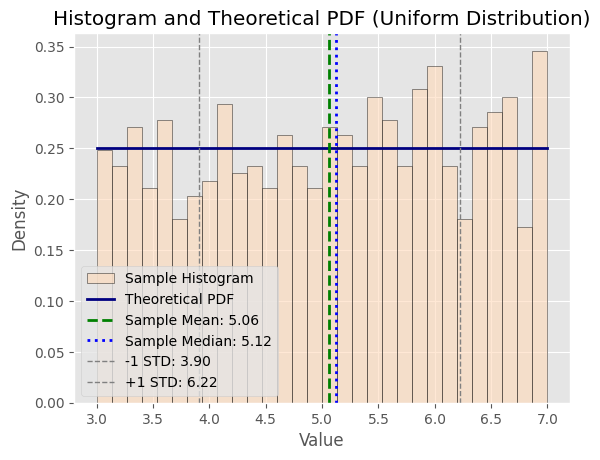

Доля значений, которые ближе к границам для выборки: 49.50%
Теоретическая доля значений для равномерного распределения: 50.00%


,Statistic,Sample Value,Theoretical Value
0,Mean,5.063130,5.000000
1,Median,5.119990,5.000000
2,Standard Deviation,1.158901,1.154701


In [173]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform
import pandas as pd

# Step 1: Generate a sample of 1000 observations from a uniform distribution over [3, 7]
a = 3
b = 7
sample_size = 1000
samples = uniform.rvs(loc=a, scale=b-a, size=sample_size)

# Theoretical values for uniform distribution
theoretical_mean = (a + b) / 2
theoretical_median = (a + b) / 2
theoretical_std = (b - a) / np.sqrt(12)  # Standard deviation formula for uniform distribution

# Step 2: Calculate sample mean, median, and standard deviation
sample_mean = np.mean(samples)
sample_median = np.median(samples)
sample_std = np.std(samples, ddof=1)

# Organize the results in a DataFrame
data = {
    "Statistic": ["Mean", "Median", "Standard Deviation"],
    "Sample Value": [sample_mean, sample_median, sample_std],
    "Theoretical Value": [theoretical_mean, theoretical_median, theoretical_std]
}
df = pd.DataFrame(data)

# Step 3: Plot a histogram and theoretical PDF for the uniform distribution
def visualize_uniform_distribution(samples, a, b, sample_mean, sample_median, sample_std):
    # Create histogram of the sample data
    plt.hist(samples, bins=30, density=True, alpha=0.6, color='peachpuff', edgecolor='black', label='Sample Histogram')

    # Theoretical PDF
    x = np.linspace(a, b, 400)
    pdf = uniform.pdf(x, loc=a, scale=b-a)
    plt.plot(x, pdf, color='navy', lw=2, label='Theoretical PDF')

    # Add sample mean, median, and std deviation lines
    plt.axvline(sample_mean, color='green', linestyle='--', lw=2, label=f'Sample Mean: {sample_mean:.2f}')
    plt.axvline(sample_median, color='blue', linestyle=':', lw=2, label=f'Sample Median: {sample_median:.2f}')
    plt.axvline(sample_mean - sample_std, color='gray', linestyle='--', lw=1, label=f'-1 STD: {sample_mean - sample_std:.2f}')
    plt.axvline(sample_mean + sample_std, color='gray', linestyle='--', lw=1, label=f'+1 STD: {sample_mean + sample_std:.2f}')

    # Add titles and labels
    plt.title('Histogram and Theoretical PDF (Uniform Distribution)')
    plt.xlabel('Value')
    plt.ylabel('Density')

    plt.legend()
    plt.show()

visualize_uniform_distribution(samples, a, b, sample_mean, sample_median, sample_std)

# Step 4: Calculate the proportion of values > 6 or < 4 for both the sample and theoretical distribution
threshold_lower = 4
threshold_upper = 6
sample_proportion = np.sum((samples < threshold_lower) | (samples > threshold_upper)) / sample_size

# Theoretical proportion for uniform distribution (area outside [4,6])
theoretical_proportion = (threshold_lower - a) / (b - a) + (b - threshold_upper) / (b - a)

print(f"Доля значений, которые ближе к границам для выборки: {sample_proportion * 100:.2f}%")
print(f"Теоретическая доля значений для равномерного распределения: {theoretical_proportion * 100:.2f}%")

# Show the DataFrame
df


### Задание 16: Распределение Пуассона (1 балл)
Генерация данных \
Сгенерируйте выборку из 1000 наблюдений из распределения Пуассона с параметром  λ=4. \
Описательная статистика \
Найдите выборочное среднее, дисперсию и моду количества событий. \
Графическое представление \
Постройте столбчатую диаграмму распределения количества событий. \
Анализ вероятностей \
Определите вероятность того, что количество событий будет меньше 3, используя как выборочные данные, так и теоретическое распределение Пуассона. Сравните результаты. \

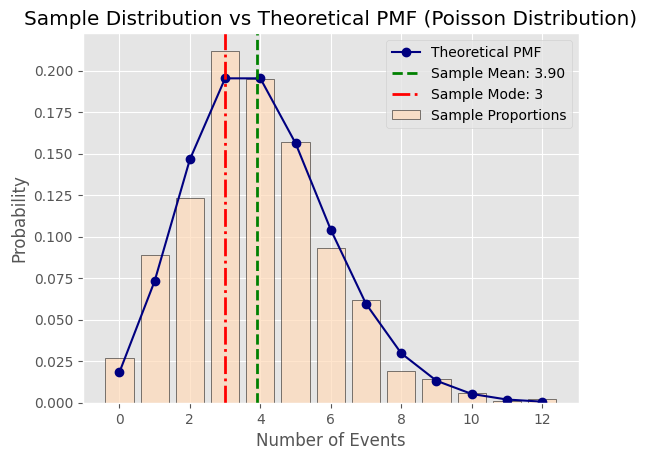

Доля событий меньше 3 для выборки: 23.90%
Теоретическая вероятность для Пуассоновского распределения: 23.81%


,Statistic,Sample Value,Theoretical Value
0,Mean,3.901000,4.0
1,Variance,4.065264,4.0
2,Mode,3.000000,4.0


In [189]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, mode
import pandas as pd

# Step 1: Generate a sample of 1000 observations from a Poisson distribution with λ=4
lambda_param = 4
sample_size = 1000
samples = poisson.rvs(mu=lambda_param, size=sample_size)

# Theoretical values for Poisson distribution
theoretical_mean = lambda_param
theoretical_variance = lambda_param
theoretical_mode = np.floor(lambda_param) if lambda_param >= 1 else 0  # Mode formula for Poisson distribution

# Step 2: Calculate sample mean, variance, and mode
sample_mean = np.mean(samples)
sample_variance = np.var(samples, ddof=1)
sample_mode, _ = mode(np.round(samples))

# Organize the results in a DataFrame
data = {
    "Statistic": ["Mean", "Variance", "Mode"],
    "Sample Value": [sample_mean, sample_variance, sample_mode],
    "Theoretical Value": [theoretical_mean, theoretical_variance, theoretical_mode]
}
df = pd.DataFrame(data)

# Step 3: Plot a bar chart for the distribution of the number of events
def visualize_poisson_distribution(samples, lambda_param, sample_mean, sample_variance, sample_mode):
    # Create bar chart for sample distribution
    values, counts = np.unique(samples, return_counts=True)
    plt.bar(values, counts/sample_size, alpha=0.7, color='peachpuff', edgecolor='black', label='Sample Proportions')

    # Theoretical PMF
    x = np.arange(0, max(samples) + 1)
    pmf = poisson.pmf(x, lambda_param)
    plt.plot(x, pmf, color='navy', marker='o', linestyle='-', label='Theoretical PMF')

    # Add sample mean, mode, variance lines
    plt.axvline(sample_mean, color='green', linestyle='--', lw=2, label=f'Sample Mean: {sample_mean:.2f}')
    plt.axvline(sample_mode, color='red', linestyle='-.', lw=2, label=f'Sample Mode: {sample_mode}')

    # Add titles and labels
    plt.title('Sample Distribution vs Theoretical PMF (Poisson Distribution)')
    plt.xlabel('Number of Events')
    plt.ylabel('Probability')

    plt.legend()
    plt.show()

visualize_poisson_distribution(samples, lambda_param, sample_mean, sample_variance, sample_mode)

# Step 4: Calculate the proportion of events < 3 for both the sample and theoretical distribution
threshold = 3
sample_proportion = np.sum(samples < threshold) / sample_size

# Theoretical probability P(X < 3) for Poisson distribution
theoretical_proportion = poisson.cdf(threshold - 1, lambda_param)

print(f"Доля событий меньше 3 для выборки: {sample_proportion * 100:.2f}%")
print(f"Теоретическая вероятность для Пуассоновского распределения: {theoretical_proportion * 100:.2f}%")

# Show the DataFrame
df


# 3 Часть

## Задание 17: Проверка несмещённости и состоятельности выборочного среднего рейтингов (3 балла все задание)
1. Вычисление генерального среднего рейтингов \
Рассчитайте выборочное среднее рейтингов всех аниме. \
2. Проверка несмещённости оценки выборочного среднего \
Сгенерируйте 1000 выборок объёма n=100 с возвращением из исходных данных.
Для каждой выборки вычислите выборочное среднее рейтингов.
Постройте гистограмму распределения полученных выборочных средних.
Вычислите среднее из выборочных средних и сравните его с генеральным средним исходных данных. Сделайте вывод о несмещенности оценки. (1 балл)
3. Проверка состоятельности оценки выборочного среднего. \
Повторите шаги из пункта 2 для различных объёмов выборки: n=50, 200, 500.
Для каждого объёма выборки вычислите дисперсию выборочных средних.
Постройте график зависимости дисперсии выборочных средних от объёма выборки.
Проанализируйте, как дисперсия уменьшается с увеличением объёма выборки. Сделайте вывод о состоятельности оценки. (1 балл)

## Задание 18: Проверка несмещённости и состоятельности медианы рейтингов (3 балла все задание)
1. Вычисление генеральной медианы \
Рассчитайте медиану рейтингов по всему датасету.
2. Проверка несмещённости медианы \
Сгенерируйте 1000 выборок объёма n=100 с возвращением.
Для каждой выборки вычислите медиану рейтингов.
Постройте гистограмму распределения полученных медиан.
Вычислите среднее из медиан и сравните с медианой исходных данных. Сделайте вывод о несмещенности оценки. (1 балл)
3. Проверка состоятельности медианы \
Повторите шаги из пункта 2 для n=50, 200, 500.
Для каждого объёма выборки вычислите стандартное отклонение медиан.
Постройте график зависимости стандартного отклонения медиан от объёма выборки.
Проанализируйте изменение разброса медиан с ростом объёма выборки. Сделайте вывод о состоятельности оценки. (1 балл)

## Задание 19: Проверка несмещённости и состоятельности выборочной дисперсии рейтингов (3 балла все задание)
1. Вычисление выборочной дисперсии \
Рассчитайте выборочную дисперсию рейтингов по всему датасету.
2. Проверка несмещённости оценки выборочной дисперсии \
Сгенерируйте 1000 выборок объёма n=100 с возвращением.
Для каждой выборки вычислите выборочную дисперсию.
Постройте гистограмму распределения полученных дисперсий.
Вычислите среднее из дисперсий и сравните с выборочной дисперсией исходных данных. Сделайте вывод о несмещенности оценки. (1 балл)
3. Проверка состоятельности оценки выборочной дисперсии \
Повторите шаги из пункта 2 для n=50, 200, 500.
Для каждого объёма выборки вычислите дисперсию оценок выборочной дисперсии.
Постройте график зависимости дисперсии оценок выборочной дисперсии от объёма выборки.
Проанализируйте изменение разброса оценок с ростом объёма выборки.  Сделайте вывод о состоятельности оценки. (1 балл)